## _Processing Stage_

- examine the output of **Processing Stage** _e.g._ build event, plot true and false edges, etc.

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
# sys.path.append('src')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

## _Config File_

In [8]:
# load processing config file (trusted source)
config_file = os.path.join(os.curdir, 'LightningModules/Processing/configs/prepare_quickstart.yaml')
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [9]:
# see params used in this stage
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(config)

{ 'chunksize': 1,
  'filtering': True,
  'input_dir': '${EXATRKX_DATA}/data_all',
  'inputedges': True,
  'layerwise': False,
  'modulewise': False,
  'n_files': 10000,
  'n_tasks': 1,
  'n_workers': 4,
  'noise': False,
  'orderwise': True,
  'output_dir': '${EXATRKX_DATA}/run/feature_store',
  'overwrite': True,
  'selection': False,
  'skewed': False}


In [10]:
# change some params here
config['n_files'] = 10

In [11]:
# see params used in this stage
pp.pprint(config)

{ 'chunksize': 1,
  'filtering': True,
  'input_dir': '${EXATRKX_DATA}/data_all',
  'inputedges': True,
  'layerwise': False,
  'modulewise': False,
  'n_files': 10,
  'n_tasks': 1,
  'n_workers': 4,
  'noise': False,
  'orderwise': True,
  'output_dir': '${EXATRKX_DATA}/run/feature_store',
  'overwrite': True,
  'selection': False,
  'skewed': False}


## _(1) - Input Data_

## _(2) - Processed Data_

In [12]:
# local imports
from src.drawing import detector_layout, draw_proc_event
from src.utils_math import polar_to_cartesian, cylindrical_to_cartesian

In [13]:
inputdir="run/feature_store"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [14]:
event_idx = 1
feature_data = torch.load(proc_files[event_idx], map_location=device)
print("Length of Data: {}".format(len(feature_data)))

Length of Data: 15


In [15]:
feature_data

Data(x=[159, 3], pid=[159], layers=[159], event_file='/export/home/adeel/current/stttrkx/data_all/event0000000001', hid=[159], pt=[159], vertex=[159, 3], charge=[159], pdgcode=[159], ptheta=[159], peta=[159], pphi=[159], orderwise_true_edges=[2, 149], edge_index=[2, 942], y_pid=[942])

- _`x, pid, layers, hid, pt, vertex, charge, pdgcode, petheta, peta`_ and _`pphi`_ should have same dimensions
- _`layerwise_true_edges, modulewise_true_edges`_ and _`orderwise_true_edges`_ can have different dimenisions from above and among themselves
- _`edge_index`_ and _`y_pid`_ should have same dimensions, since _`edge_index`_ is the input and _`y_pid`_ is the output given to neural network

In [16]:
# x=[r,phi,isochrone]
feature_data.x.shape

torch.Size([159, 3])

In [17]:
feature_data.pid.shape

torch.Size([159])

In [18]:
feature_data.orderwise_true_edges.shape

torch.Size([2, 149])

In [19]:
feature_data.edge_index.shape

torch.Size([2, 942])

In [20]:
feature_data.y_pid.shape

torch.Size([942])

In [21]:
feature_data.event_file

'/export/home/adeel/current/stttrkx/data_all/event0000000001'

In [22]:
# extract event_id from 'feature_data.event_file'
int(os.path.basename(feature_data.event_file)[-10:])

1

In [23]:
# event_prefix from 'feature_data'
feature_data.event_file[-15:]

'event0000000001'

In [24]:
# extract 'event_id' from 'feature_data'
int(feature_data.event_file[-10:])

1

In [25]:
# recreate 'event_prefix' from 'event_id'
str('event{!s}'.format(format(event_idx, '010d')))

'event0000000001'

In [26]:
# OR, recreate 'event_prefix' from 'event_id'
"event{:010d}".format(1)

'event0000000001'

In [27]:
# get 'event_file' from dirname+event_prefix
os.path.join(os.path.dirname(feature_data.event_file), "event{:010d}".format(1))

'/export/home/adeel/current/stttrkx/data_all/event0000000001'

## _(3) - Display Event_

In [28]:
# draw a processed event
# draw_proc_event(feature_data, figsize=(10,10), save_fig=False);

## _(4) - Plotting Edges_

- _True Edges (Layerwise, Modulewise, Orderwise)_
- _False Edges (Heuristic Method, Metric Learning)_
- _Input Edges (All True and False together)_

In [29]:
event_idx = 1
feature_data = torch.load(proc_files[event_idx], map_location=device)
print("Length of Data: {}".format(len(feature_data)))

Length of Data: 15


- In _`feature_data`_, we have _`true_edges`_, and _`edge_index`_ (_a.k.a_ input graph). The `edge_index` contains both `true` and `false` edges. However, we have `edge_index` truth as `y` or `y_pid`. So by using `y_pid==1(0)` one can query only `true (false)` edges. Here, we will use `edge_index` and `y/y_pid` to plot our edges.

In [30]:
# feature_data

In [31]:
# check datatypes of Data objects
# for key, value in feature_data:
#    print(f"{key}: {type(value)}")

### _(4.1) - True Edges_

- plotting _**true edges**_ directly from _`xxx_true_edges`_ available in _`feature_data`_

In [32]:
# Get some fields (note all are torch.Tensor)
x = feature_data.x
pids = feature_data.pid
true_edges = feature_data.orderwise_true_edges

In [33]:
# [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

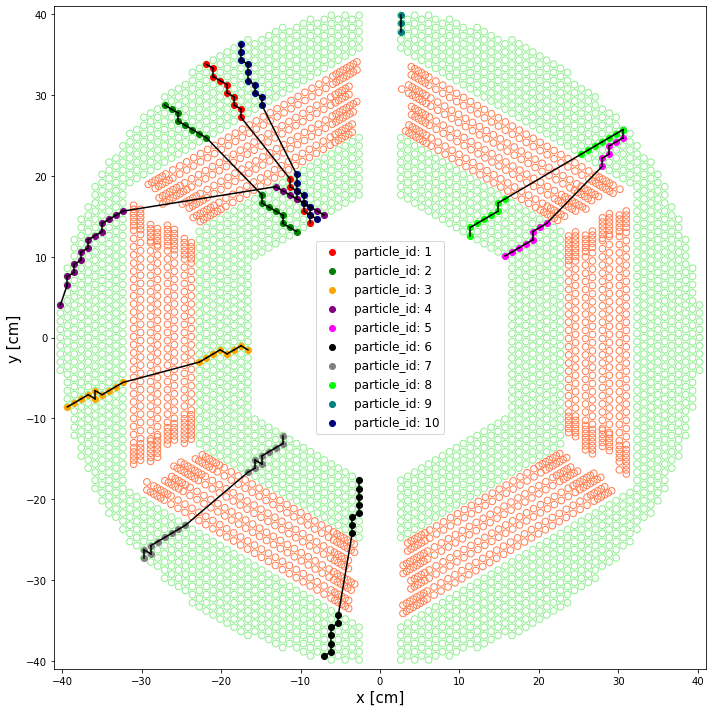

In [34]:
# Method 1: plotting ground truth directly from true_edges

plt.close('all')
fig, ax = detector_layout(figsize=(10,10))

# cmap = plt.get_cmap('tab20')
cmap = ['blue', 'red', 'green', 'orange', 'purple', 'magenta', 'black', 
        'gray', 'lime', 'teal', 'navy', 'maroon', 'olive', 'indigo', 'cyan']

# particle tracks
unique_pids =  np.unique(pids)
for pid in unique_pids:
    mask = (feature_data.pid == pid)
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f'particle_id: {pid}')

# true edges (note: true edges are randomly plotted)
# for i, (source, target) in enumerate(true_edges.T):
for (source, target) in true_edges.T:
    ax.plot([x[source], x[target]], [y[source], y[target]], color='k')

# axis params
ax.legend(fontsize=12, loc='best')
fig.tight_layout()
# fig.savefig("true_edges_1.pdf")

- plotting _**true edges**_ from _`edge_idex`_ (input graph) available in _`feature_data`_

In [35]:
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index
true_edges = (pids[e[0]] == pids[e[1]])

In [36]:
# [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

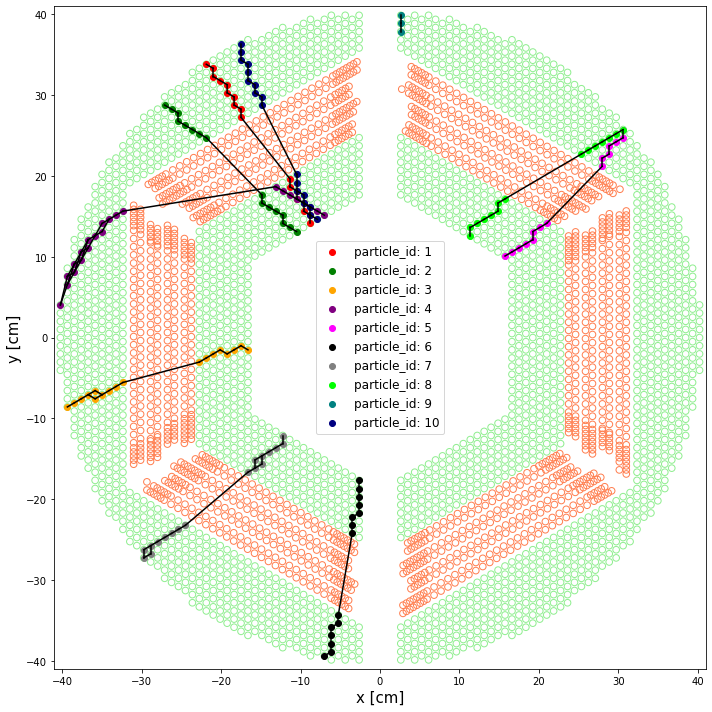

In [37]:
# Method 2: plotting ground truth from edge_idex

plt.close('all')
fig, ax = detector_layout(figsize=(10,10))

# cmap = plt.get_cmap('tab20')
cmap = ['blue', 'red', 'green', 'orange', 'purple', 'magenta', 'black', 
        'gray', 'lime', 'teal', 'navy', 'maroon', 'olive', 'indigo', 'cyan']

# particle tracks
unique_pids =  np.unique(pids)
for pid in unique_pids:
    mask = (feature_data.pid == pid)
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f'particle_id: {pid}')

# true edges (note: true edges are randomly plotted)
ax.plot(x[e[:, true_edges]], y[e[:, true_edges]], c="k")

# axis params
ax.legend(fontsize=12, loc='best')
fig.tight_layout()
# fig.savefig("true_edges_2.pdf")

### _(4.2) - False Edges_

- plotting _**false edges**_ from _`edge_idex`_ (input graph) available in _`feature_data`_

In [38]:
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index
false_edges = (pids[e[0]] != pids[e[1]])     # alternatively: false_edges = ~true_edges

In [39]:
# [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

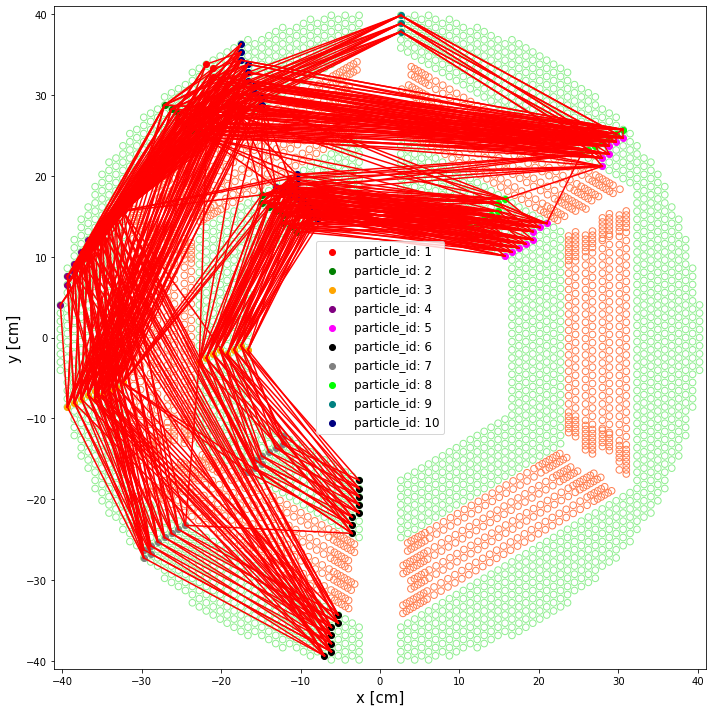

In [40]:
# plotting false edges from edge_idex

plt.close('all')
fig, ax = detector_layout(figsize=(10,10))

# cmap = plt.get_cmap('tab20')
cmap = ['blue', 'red', 'green', 'orange', 'purple', 'magenta', 'black', 
        'gray', 'lime', 'teal', 'navy', 'maroon', 'olive', 'indigo', 'cyan']

# particle tracks
unique_pids =  np.unique(pids)
for pid in unique_pids:
    mask = (feature_data.pid == pid)
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f'particle_id: {pid}')

# false edges (note: false edges are randomly plotted)
ax.plot(x[e[:, (~true_edges)]], y[e[:, (~true_edges)]], color='r')

# axis params
ax.legend(fontsize=12, loc='best')
fig.tight_layout()
# fig.savefig("false_edges.pdf")

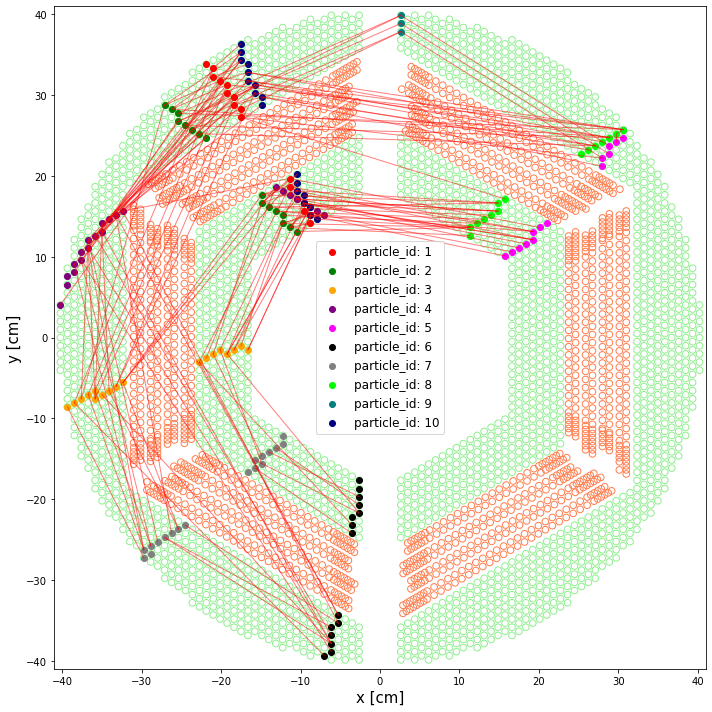

In [41]:
# plotting false edges from edge_idex (thinout)

plt.close('all')
fig, ax = detector_layout(figsize=(10,10))

# cmap = plt.get_cmap('tab20')
cmap = ['blue', 'red', 'green', 'orange', 'purple', 'magenta', 'black', 
        'gray', 'lime', 'teal', 'navy', 'maroon', 'olive', 'indigo', 'cyan']

# particle tracks
unique_pids =  np.unique(pids)
for pid in unique_pids:
    mask = (feature_data.pid == pid)
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f'particle_id: {pid}')

# false edges (note: false edges are randomly plotted)
ax.plot(x[e[:, (~true_edges)][:, 0:-1:5]], y[e[:, (~true_edges)][:, 0:-1:5]], color='r', alpha=0.5, lw=1)

# axis params
ax.legend(fontsize=12, loc='best')
fig.tight_layout()
# fig.savefig("false_edges_thin.pdf")

### _(4.3) - Input Edges_

- plotting _**input edges**_ from _`edge_idex`_ (all edges) available in _`feature_data`_

In [42]:
x = feature_data.x
pids = feature_data.pid
edge_index = feature_data.edge_index

In [43]:
# [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

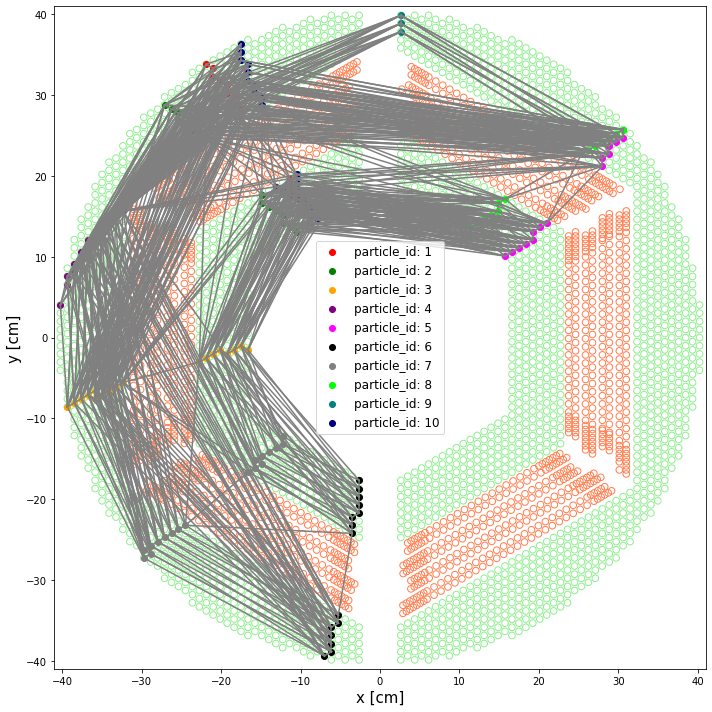

In [44]:
# Method 1: plotting input edges from edge_index

plt.close('all')
fig, ax = detector_layout(figsize=(10,10))

# cmap = plt.get_cmap('tab20')
cmap = ['blue', 'red', 'green', 'orange', 'purple', 'magenta', 'black', 
        'gray', 'lime', 'teal', 'navy', 'maroon', 'olive', 'indigo', 'cyan']

# particle tracks
unique_pids =  np.unique(pids)
for pid in unique_pids:
    mask = (feature_data.pid == pid)
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f'particle_id: {pid}')

# input edges (note: input_edges ~ edge_index)
# for i, (source, target) in enumerate(edge_index.T):
for (source, target) in edge_index.T:
    ax.plot([x[source], x[target]], [y[source], y[target]], color='grey')

# axis params
ax.legend(fontsize=12, loc='best')
fig.tight_layout()
# fig.savefig("input_edges_1.pdf")

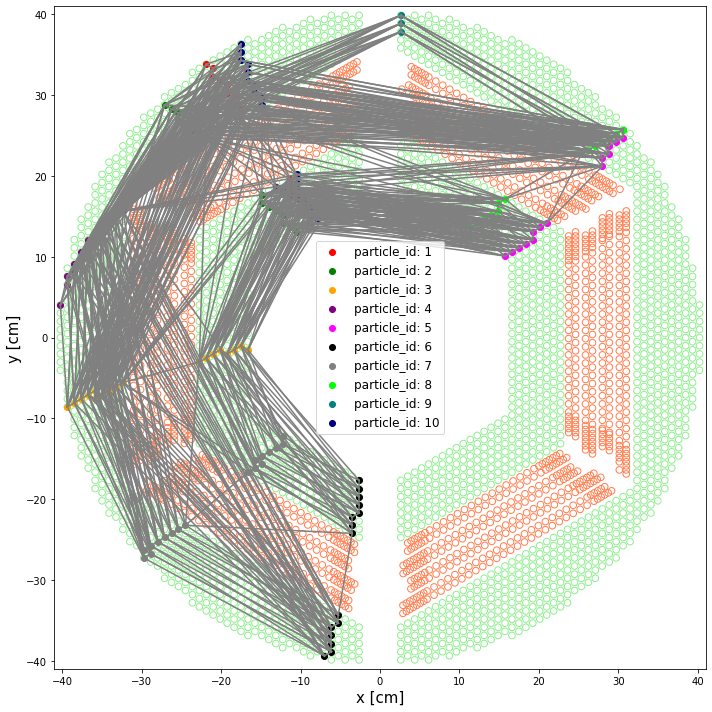

In [45]:
# Method 2: plotting input edges from edge_index

plt.close('all')
fig, ax = detector_layout(figsize=(10,10))

# cmap = plt.get_cmap('tab20')
cmap = ['blue', 'red', 'green', 'orange', 'purple', 'magenta', 'black', 
        'gray', 'lime', 'teal', 'navy', 'maroon', 'olive', 'indigo', 'cyan']

# particle tracks
unique_pids =  np.unique(pids)
for pid in unique_pids:
    mask = (feature_data.pid == pid)
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f'particle_id: {pid}')

# true edges (note: true edges are randomly plotted)
ax.plot(x[e[:, :]], y[e[:, :]], c="grey")

# axis params
ax.legend(fontsize=12, loc='best')
fig.tight_layout()
# fig.savefig("true_edges_2.pdf")

## _(5) - Plotting Edges (Old)_

- _True Edges (Layerwise, Modulewise, Orderwise)_
- _False Edges (Heuristic Method, Metric Learning)_
- _Input Edges (All True and False together)_

In [46]:
x = feature_data.x
pids = feature_data.pid

In [47]:
# [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

### _(+) - Plotting True Edges_

In _feature_data_, we have _`layerwise_true_edges`_, _`modulewise_true_edges`_ and _`edge_index`_ (_a.k.a_ input graph). The _`edge_index`_ contains both _`true`_ and _`false`_ edges. However, we have _`edge_index`_ truth as _`y`_ or _`y_pid`_. So by using _`y_pid==1(0)`_ one can query only _`true (false)`_ edges.

Let's separate true edges:

In [48]:
# get true edges (might be wrong)
true_idx = np.where(feature_data.y_pid==True)[0]
true_edges = feature_data.edge_index.T[true_idx].T  # New: true_edges = (pids[e[0]] == pids[e[1]])

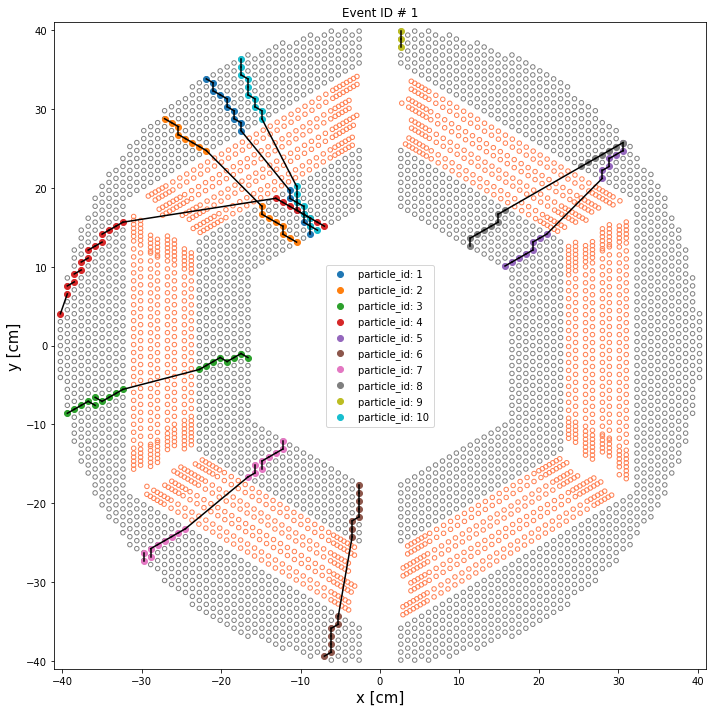

In [49]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
ax.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='grey')
ax.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')
    
# particle tracks
unique_pids =  np.unique(pids)
for pid in unique_pids:
    mask = (feature_data.pid == pid)
    ax.scatter(x[mask], y[mask], label='particle_id: %d' %pid)
    
# true edges
for iedge in range(true_edges.shape[1]):
    ptx1 = x[true_edges[0][iedge]]
    ptx2 = x[true_edges[1][iedge]]
    pty1 = y[true_edges[0][iedge]]
    pty2 = y[true_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color='k')

# plotting params
ax.set_title('Event ID # %d' % event_idx)
ax.set_xlabel('x [cm]', fontsize=15)
ax.set_ylabel('y [cm]', fontsize=15)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_edges.png")

### _(+) - Plotting False Edges_

In _feature_data_, we have _`layerwise_true_edges`_, _`modulewise_true_edges`_ and _`edge_index`_ (_a.k.a_ input graph). The _`edge_index`_ contains both _`true`_ and _`false`_ edges. However, we have _`edge_index`_ truth as _`y`_ or _`y_pid`_. So by using _`y_pid==1(0)`_ one can query only _`true (false)`_ edges.

Let's separate false edges:

In [50]:
# get false edges (might be wrong)
false_idx = np.where(feature_data.y_pid==False)[0]
false_edges = feature_data.edge_index.T[false_idx].T  # new: false_edges = (pids[e[0]] != pids[e[1]])

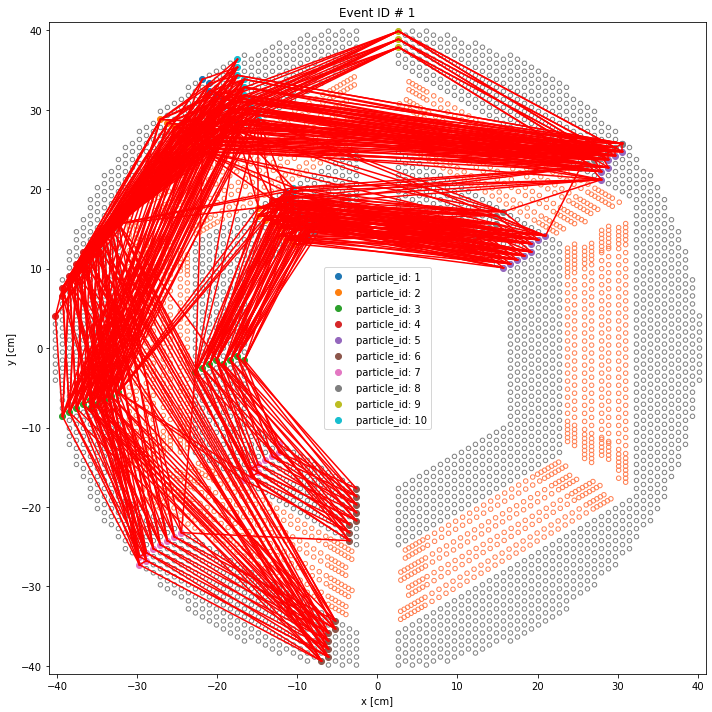

In [51]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
ax.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='grey')
ax.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# particle tracks
unique_pids =  np.unique(pids)
for pid in unique_pids:
    mask = (feature_data.pid == pid)
    ax.scatter(x[mask], y[mask], label='particle_id: %d' %pid)
    
# input edges
for iedge in range(false_edges.shape[1]):
#for iedge in range(56):
    ptx1 = x[false_edges[0][iedge]]
    ptx2 = x[false_edges[1][iedge]]
    pty1 = y[false_edges[0][iedge]]
    pty2 = y[false_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color='r')

# plotting params
ax.set_title('Event ID # %d' % event_idx)
ax.set_xlabel('x [cm]', fontsize=10)
ax.set_ylabel('y [cm]', fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("false_edges.png")

### _(+) - Plotting Input Edges_

In [52]:
# get all edges
input_edges = feature_data.edge_index

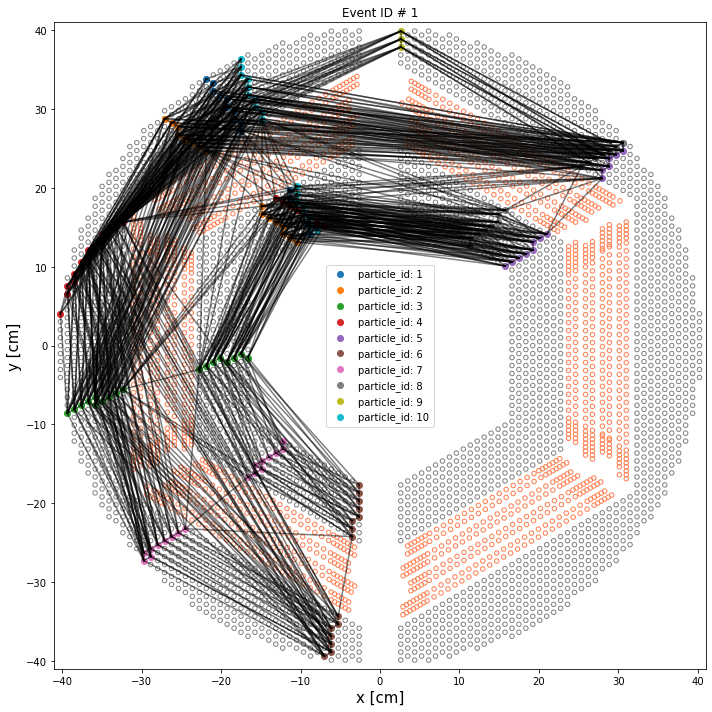

In [53]:
# plotting input edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
ax.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='grey')
ax.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')
    
# particle tracks
unique_pids =  np.unique(pids)
for pid in unique_pids:
    mask = (feature_data.pid == pid)
    ax.scatter(x[mask], y[mask], label='particle_id: %d' %pid)
    
# input edges
for iedge in range(input_edges.shape[1]):
    ptx1 = x[input_edges[0][iedge]]
    ptx2 = x[input_edges[1][iedge]]
    pty1 = y[input_edges[0][iedge]]
    pty2 = y[input_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=0.5, lw=1.5)

# plotting params
ax.set_title('Event ID # %d' % event_idx)
ax.set_xlabel('x [cm]', fontsize=15)
ax.set_ylabel('y [cm]', fontsize=15)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")

## _Plot Ture or False Edges_

- code from _`notebooks/example_gnn.ipynb`_, used above.

- True Edges

- False Edges